In [ ]:
#This portion deals with the pre-processing of a few text data and also sentiment analysis employing various NLP models like Bert, SpaCy and Vert.
#Installing necessary libraries and modules to carry out pre-prpcesisng of data successfully:
%pip install vaderSentiment
%pip install emoji
%pip install demoji
%pip install ekphrasis
%pip install deep_translator
%pip install langdetect
%pip install cleantext
%pip install unidecode
%pip install googletrans==4.0.0-rc1
%pip install spaCy
%pip install gensim
%pip install tf-keras
%pip install spacy
%pip install transformers nltk emoji textblob torch pandas googletrans
%pip install wordcloud matplotlib
%pip install plotly


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This b

In [1]:
#Import necessary libraries and modules:
import torch
from transformers import AutoTokenizer, AutoModel, pipeline
from typing import List, Dict, Tuple, Optional, Union
import re
import emoji
import demoji
from deep_translator import GoogleTranslator
from langdetect import detect, LangDetectException
from cleantext import clean
from unidecode import unidecode
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import spacy
from textblob import TextBlob
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import json
import logging
from datetime import datetime
import spacy
spacy.cli.download("en_core_web_sm")
from transformers import BertTokenizer, BertForSequenceClassification
from nltk.sentiment import SentimentIntensityAnalyzer


/Users/user/anaconda3/envs/sentiment-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.1 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd

# Loading the CSV file that contains the comments and other related information:
csv_path = "/Users/user/Desktop/Project Submission/Implementation/Source Code/Text Data/comments.csv"  # Specifying the path here
df = pd.read_csv(csv_path)

# Printing first few rows to see how it looks:
print(df.head())

   COMMENT_ID                                       USER_COMMENT     SOURCE  \
0           2                                   Did it again❤️👏🙌  Instagram   
1          22                                        Stunning!!!  Instagram   
2           8                                 Outdid yourself 🧡🧡  Instagram   
3         132                      I need a documentary on this!  Instagram   
4         133  We need long form Daniel Roseberry content please  Instagram   

                                         COMMENT_URL  \
0  https://www.instagram.com/p/DFyH2bHN2v5/?img_i...   
1  https://www.instagram.com/p/DFyH2bHN2v5/?img_i...   
2  https://www.instagram.com/p/DFyH2bHN2v5/?img_i...   
3           https://www.instagram.com/p/DFiu7tfNqSN/   
4           https://www.instagram.com/p/DFiu7tfNqSN/   

                     CREATED_AT FASHION_HOUSE  
0  05-MAR-25 02.14.50.377081 PM  Schiaparelli  
1  05-MAR-25 02.24.45.267567 PM  Schiaparelli  
2  05-MAR-25 02.25.43.847212 PM  Schiaparell

In [3]:
#Loading one row of data from the dataframe:
print(df.values[58])
print("The dataset gives information about comment ids, the comment itself,"
" URL of the instagram post from which the comment was received from,"
"date this comment was obtained and lastly, which fashion house's instagram handled was used to get the data.")

[270
 'These critical commts are from people that probably dont shop clothes from the brand and are probably not working in design. The team there are talented and positions earned were not easy to come by. Chanel hasn’t been a brand you go to for avant garde-for decades it’s been like this. Blazy probably will change it but these cmmts are funny'
 'Instagram' 'https://www.instagram.com/p/DFYqfGOOWW3/?img_index=1'
 '09-MAR-25 02.24.11.470155 PM' 'Chanel']
The dataset gives information about comment ids, the comment itself, URL of the instagram post from which the comment was received from,date this comment was obtained and lastly, which fashion house's instagram handled was used to get the data.


In [4]:
class SentimentAnalyzer:
    def __init__(self):
        # Initialize BERT for general sentiment
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        self.model.eval()
        
        # Initialize emotion detector
        self.emotion_classifier = pipeline(
            "text-classification",
            model="j-hartmann/emotion-english-distilroberta-base",
            return_all_scores=True
        )
        
        # Initialize VADER analyzer
        self.vader = SentimentIntensityAnalyzer()
        
        # Initialize NLTK components
        nltk.download('punkt')
        nltk.download('stopwords')
        nltk.download('wordnet')
        nltk.download('averaged_perceptron_tagger')
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        # Initialize emoji translator
        demoji.download_codes()
        
        # Initialize social media text processor
        self.text_processor = TextPreProcessor(
            normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
                      'time', 'date', 'number'],
            annotate={"hashtag", "allcaps", "elongated", "repeated",
                     "emphasis", "censored"},
            fix_html=True,
            segmenter="twitter",
            corrector="twitter", 
            unpack_hashtags=True,
            unpack_contractions=True,
            spell_correct_elong=False,
            tokenizer=SocialTokenizer(lowercase=True).tokenize,
            dicts=[emoticons]
        )
        
        # Fashion-specific aspects to analyze
        self.aspects = {
            'design': ['design', 'style', 'pattern', 'cut', 'silhouette'],
            'quality': ['quality', 'fabric', 'material', 'craftsmanship'],
            'aesthetic': ['beautiful', 'gorgeous', 'stunning', 'elegant', 'chic'],
            'innovation': ['innovative', 'creative', 'unique', 'original'],
            'wearability': ['wearable', 'practical', 'comfortable']
        }
        
        # Emoji sentiment mapping
        self.emoji_sentiment = self._initialize_emoji_sentiment()
        
    def _initialize_emoji_sentiment(self) -> Dict[str, float]:
        """Initialize emoji sentiment scores."""
        positive_emojis = ['❤️', '😍', '🥰', '😊', '🔥', '✨', '💯', '👏', '🙌', '💖']
        negative_emojis = ['😢', '😭', '😤', '😠', '😡', '👎', '💔', '😒', '🙄', '😩']
        neutral_emojis = ['🤔', '😐', '😶', '💭', '💬', '🗨️', '💡', '📝', '🔍', '⚡']
        
        emoji_scores = {}
        for e in positive_emojis:
            emoji_scores[e] = 1.0
        for e in negative_emojis:
            emoji_scores[e] = -1.0
        for e in neutral_emojis:
            emoji_scores[e] = 0.0
            
        return emoji_scores

    def extract_emojis(self, text: str) -> Tuple[List[str], str]:
        """Extract emojis and return both emoji list and cleaned text."""
        emoji_list = [c for c in text if c in emoji.EMOJI_DATA]
        cleaned_text = ''.join(c for c in text if c not in emoji.EMOJI_DATA)
        return emoji_list, cleaned_text

    def analyze_emojis(self, emoji_list: List[str]) -> Dict[str, Union[float, int]]:
        """Analyze sentiment and frequency of emojis."""
        if not emoji_list:
            return {'sentiment': 0.0, 'count': 0, 'frequencies': {}}
        
        total_sentiment = 0
        frequencies = {}
        
        for e in emoji_list:
            if e in self.emoji_sentiment:
                total_sentiment += self.emoji_sentiment[e]
            frequencies[e] = frequencies.get(e, 0) + 1
        
        return {
            'sentiment': total_sentiment / len(emoji_list),
            'count': len(emoji_list),
            'frequencies': frequencies
        }

    def handle_multilingual(self, text: str) -> str:
        """Handle multilingual comments by translating to English."""
        try:
            # Detect and translate non-English text
            translator = GoogleTranslator(source='auto', target='en')
            return translator.translate(text) or text
        except Exception:
            return text

    def preprocess_text(self, text: str) -> str:
        """Enhanced text preprocessing with social media and emoji handling."""
        # Extract emojis first
        emoji_list, text = self.extract_emojis(text)
        
        # Handle multilingual text
        text = self.handle_multilingual(text)
        
        # Process social media specific elements
        text = ' '.join(self.text_processor.pre_process_doc(text))
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Handle special characters while preserving emojis
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', '', text)
        
        # Tokenization
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens 
                 if token not in self.stop_words]
        
        # Add back emojis as special tokens
        processed_text = ' '.join(tokens)
        if emoji_list:
            processed_text += ' ' + ' '.join(emoji_list)
        
        return processed_text

    def get_emotion_scores(self, text: str) -> Dict[str, float]:
        """Enhanced emotion detection including emoji-based emotions."""
        # Get emotions from text
        emotions = self.emotion_classifier(text)[0]
        emotion_scores = {item['label']: item['score'] for item in emotions}
        
        # Extract and analyze emojis
        emoji_list, _ = self.extract_emojis(text)
        if emoji_list:
            emoji_analysis = self.analyze_emojis(emoji_list)
            # Adjust emotion scores based on emojis
            if emoji_analysis['sentiment'] > 0:
                emotion_scores['joy'] = (emotion_scores.get('joy', 0) + emoji_analysis['sentiment']) / 2
            elif emoji_analysis['sentiment'] < 0:
                emotion_scores['sadness'] = (emotion_scores.get('sadness', 0) - emoji_analysis['sentiment']) / 2
        
        return emotion_scores

    def analyze_aspects(self, text: str) -> Dict[str, Dict[str, float]]:
        """Enhanced aspect-based sentiment analysis with emoji consideration."""
        aspect_sentiments = {}
        emoji_list, cleaned_text = self.extract_emojis(text)
        
        for aspect, keywords in self.aspects.items():
            relevant_sentences = []
            for sentence in nltk.sent_tokenize(cleaned_text):
                if any(keyword in sentence.lower() for keyword in keywords):
                    relevant_sentences.append(sentence)
            
            if relevant_sentences:
                sentiments = []
                for sentence in relevant_sentences:
                    # Combine VADER sentiment with emoji sentiment
                    vader_scores = self.vader.polarity_scores(sentence)
                    sentiments.append(vader_scores['compound'])
                
                # Include emoji sentiment if emojis are present in the same context
                if emoji_list:
                    emoji_analysis = self.analyze_emojis(emoji_list)
                    sentiments.append(emoji_analysis['sentiment'])
                
                aspect_sentiments[aspect] = {
                    'score': np.mean(sentiments),
                    'count': len(relevant_sentences),
                    'emoji_count': len(emoji_list) if emoji_list else 0
                }
        
        return aspect_sentiments

    def analyze_comments(self, comments: List[str]) -> List[Dict[str, Union[str, Dict]]]:
        """Enhanced comprehensive sentiment analysis including emoji analysis."""
        results = []
        
        for comment in comments:
            # Extract emojis first
            emoji_list, cleaned_text = self.extract_emojis(comment)
            
            # Preprocess text
            processed_text = self.preprocess_text(comment)
            
            # Skip empty comments after preprocessing
            if not processed_text and not emoji_list:
                continue
            
            # BERT sentiment analysis
            inputs = self.tokenizer(processed_text, 
                                  return_tensors="pt",
                                  truncation=True,
                                  max_length=512,
                                  padding=True)
            
            with torch.no_grad():
                outputs = self.model(**inputs)
                predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            
            bert_sentiment = {
                'positive': float(predictions[0][1]),
                'negative': float(predictions[0][0])
            }
            
            # VADER sentiment with emoji consideration
            vader_scores = self.vader.polarity_scores(processed_text)
            
            # Emoji analysis
            emoji_analysis = self.analyze_emojis(emoji_list)
            
            # Emotion analysis
            emotions = self.get_emotion_scores(processed_text)
            
            # Aspect-based analysis
            aspects = self.analyze_aspects(comment)
            
            # TextBlob for subjectivity
            blob = TextBlob(processed_text)
            
            results.append({
                'comment': comment,
                'processed_text': processed_text,
                'bert_sentiment': bert_sentiment,
                'vader_sentiment': vader_scores,
                'emoji_analysis': emoji_analysis,
                'emotions': emotions,
                'aspects': aspects,
                'subjectivity': blob.sentiment.subjectivity,
                'language_features': {
                    'emojis': len(emoji_list),
                    'words': len(processed_text.split()),
                    'has_hashtags': '#' in comment,
                    'has_mentions': '@' in comment
                }
            })
            
        return results
    
    def aggregate_sentiment(self, results: List[Dict[str, Union[str, Dict]]]) -> Dict[str, Union[float, Dict]]:
        """Enhanced aggregation including emoji statistics."""
        if not results:
            return {}
        
        # Convert results to DataFrame for easier aggregation
        df = pd.DataFrame(results)
        
        # Aggregate BERT sentiment
        bert_sentiments = pd.DataFrame([r['bert_sentiment'] for r in results])
        
        # Aggregate VADER sentiment
        vader_sentiments = pd.DataFrame([r['vader_sentiment'] for r in results])
        
        # Aggregate emoji analysis
        emoji_analyses = pd.DataFrame([r['emoji_analysis'] for r in results])
        
        # Aggregate emotions
        emotions = pd.DataFrame([r['emotions'] for r in results])
        
        # Aggregate aspects
        all_aspects = {}
        for result in results:
            for aspect, scores in result['aspects'].items():
                if aspect not in all_aspects:
                    all_aspects[aspect] = []
                all_aspects[aspect].append(scores['score'])
        
        aspect_averages = {
            aspect: np.mean(scores) for aspect, scores in all_aspects.items()
        }
        
        # Calculate emoji statistics
        total_emojis = sum(analysis['count'] for analysis in df['emoji_analysis'])
        emoji_frequencies = {}
        for analysis in df['emoji_analysis']:
            for emoji, count in analysis['frequencies'].items():
                emoji_frequencies[emoji] = emoji_frequencies.get(emoji, 0) + count
        
        return {
            'bert': {
                'positive': float(bert_sentiments['positive'].mean()),
                'negative': float(bert_sentiments['negative'].mean()),
                'overall': float(bert_sentiments['positive'].mean() - bert_sentiments['negative'].mean())
            },
            'vader': {
                'compound': float(vader_sentiments['compound'].mean()),
                'positive': float(vader_sentiments['pos'].mean()),
                'negative': float(vader_sentiments['neg'].mean()),
                'neutral': float(vader_sentiments['neu'].mean())
            },
            'emoji_stats': {
                'total_count': total_emojis,
                'average_per_comment': total_emojis / len(results),
                'frequencies': emoji_frequencies,
                'sentiment': float(emoji_analyses['sentiment'].mean())
            },
            'emotions': {
                emotion: float(emotions[emotion].mean()) for emotion in emotions.columns
            },
            'aspects': aspect_averages
        }


In [7]:
# Instantiate the SentimentAnalyzer
sentiment_analyzer = SentimentAnalyzer()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
/Users/user/anaconda3/envs/sentiment-env/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


/Users/user/anaconda3/envs/sentiment-env/lib/python3.9/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [5]:
import pandas as pd

# Extract the 'USER_COMMENT' columns to comments
comments = df['USER_COMMENT'].tolist()

# Check the first few rows to ensure it's correct
print(comments[:5])  # Print first 5 rows



['Did it again❤️👏🙌', 'Stunning!!!', 'Outdid yourself 🧡🧡', 'I need a documentary on this!', 'We need long form Daniel Roseberry content please']


In [8]:
# Analyze comments
analysis_results = sentiment_analyzer.analyze_comments(comments)


In [9]:
# Create a new DataFrame combining 'COMMENT_ID', 'FASHION_HOUSE', and analysis results
def create_analysis_df(df, analysis_results):
    # Ensure the input df is a DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError("df must be a pandas DataFrame")

    # Create a new DataFrame with 'COMMENT_ID' and 'FASHION_HOUSE' from df
    # and all columns from the analysis results
    analysis_df = pd.DataFrame([{
        'comment_id': df.iloc[i]['COMMENT_ID'],
        'fashion_house': df.iloc[i]['FASHION_HOUSE'],
        **result  # Adding all columns from the analysis results
    } for i, result in enumerate(analysis_results)])

    return analysis_df

# Usage
# df` is our DataFrame and `analysis_results` contains the results
analysis_df = create_analysis_df(df, analysis_results)
print(analysis_df)

     comment_id fashion_house  \
0             2  Schiaparelli   
1            22  Schiaparelli   
2             8  Schiaparelli   
3           132  Schiaparelli   
4           133  Schiaparelli   
..          ...           ...   
254         239  Schiaparelli   
255         240  Schiaparelli   
256         301  Schiaparelli   
257         302  Schiaparelli   
258         303  Schiaparelli   

                                               comment  \
0                                     Did it again❤️👏🙌   
1                                          Stunning!!!   
2                                   Outdid yourself 🧡🧡   
3                        I need a documentary on this!   
4    We need long form Daniel Roseberry content please   
..                                                 ...   
254                           I live for your posts ❤️   
255        Daniel Roseberry killing the game ❤️‍❤️‍❤️‍   
256                                        yesss!! ✨⭐️   
257                    

In [10]:
# Save the merged DataFrame to a CSV file
analysis_df.to_csv('merged_comments_with_sentiment.csv', index=False)

print("CSV file saved successfully.")

CSV file saved successfully.


In [10]:
import os

# Get the path to the desktop
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "merged_comments_with_sentiment.csv")

# Save the merged DataFrame to CSV on the desktop
analysis_df.to_csv(desktop_path, index=False)

print(f"CSV file saved successfully on your desktop: {desktop_path}")


CSV file saved successfully on your desktop: /Users/user/Desktop/merged_comments_with_sentiment.csv


In [11]:
# Now that we have expanded the nested columns, we can print the analysis_df to check
print(analysis_df)

     comment_id fashion_house  \
0             2  Schiaparelli   
1            22  Schiaparelli   
2             8  Schiaparelli   
3           132  Schiaparelli   
4           133  Schiaparelli   
..          ...           ...   
254         239  Schiaparelli   
255         240  Schiaparelli   
256         301  Schiaparelli   
257         302  Schiaparelli   
258         303  Schiaparelli   

                                               comment  \
0                                     Did it again❤️👏🙌   
1                                          Stunning!!!   
2                                   Outdid yourself 🧡🧡   
3                        I need a documentary on this!   
4    We need long form Daniel Roseberry content please   
..                                                 ...   
254                           I live for your posts ❤️   
255        Daniel Roseberry killing the game ❤️‍❤️‍❤️‍   
256                                        yesss!! ✨⭐️   
257                    

In [12]:
# Create a new DataFrame combining 'COMMENT_ID', 'FASHION_HOUSE', and analysis results
def create_analysis_df(df, analysis_results):
    # Ensure the input df is a DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError("df must be a pandas DataFrame")

    # Create a new DataFrame with 'COMMENT_ID' and 'FASHION_HOUSE' from df
    # and all columns from the analysis results
    analysis_df = pd.DataFrame([{
        'comment_id': df.iloc[i]['COMMENT_ID'],
        'fashion_house': df.iloc[i]['FASHION_HOUSE'],
        **result  # Adding all columns from the analysis results
    } for i, result in enumerate(analysis_results)])

    return analysis_df

# Usage
# df` is our DataFrame and `analysis_results` contains the results
analysis_df = create_analysis_df(df, analysis_results)
print(analysis_df)

     comment_id fashion_house  \
0             2  Schiaparelli   
1            22  Schiaparelli   
2             8  Schiaparelli   
3           132  Schiaparelli   
4           133  Schiaparelli   
..          ...           ...   
254         239  Schiaparelli   
255         240  Schiaparelli   
256         301  Schiaparelli   
257         302  Schiaparelli   
258         303  Schiaparelli   

                                               comment  \
0                                     Did it again❤️👏🙌   
1                                          Stunning!!!   
2                                   Outdid yourself 🧡🧡   
3                        I need a documentary on this!   
4    We need long form Daniel Roseberry content please   
..                                                 ...   
254                           I live for your posts ❤️   
255        Daniel Roseberry killing the game ❤️‍❤️‍❤️‍   
256                                        yesss!! ✨⭐️   
257                    

In [13]:
import pandas as pd
from collections import Counter
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
import nltk

# Make sure NLTK data is available
nltk.download('opinion_lexicon')
nltk.download('punkt')

# Function to extract dominant sentiment and its score
def extract_sentiment_info(sentiment_dict):
    if isinstance(sentiment_dict, dict):
        label = max(sentiment_dict, key=sentiment_dict.get)
        score = sentiment_dict[label]
        return pd.Series([label, score])
    return pd.Series([None, None])

# Apply function to 'bert_sentiment' and 'vader_sentiment' columns
analysis_df[['bert_label', 'bert_score']] = analysis_df['bert_sentiment'].apply(extract_sentiment_info)
analysis_df[['vader_label', 'vader_score']] = analysis_df['vader_sentiment'].apply(extract_sentiment_info)

# 1. Average Sentiment Score (using BERT or VADER)
average_bert_score = analysis_df['bert_score'].mean()
average_vader_score = analysis_df['vader_score'].mean()

print("Average BERT Sentiment Score:", average_bert_score)
print("Average VADER Sentiment Score:", average_vader_score)

# 2. Sentiment Distribution in Percentage Terms
# For BERT sentiment
bert_label_dist = analysis_df['bert_label'].value_counts(normalize=True) * 100
print("\nBERT Sentiment Distribution (%):")
print(bert_label_dist)

# For VADER sentiment
vader_label_dist = analysis_df['vader_label'].value_counts(normalize=True) * 100
print("\nVADER Sentiment Distribution (%):")
print(vader_label_dist)

# 3. Top Positive and Negative Words (Based on Opinion Lexicon)
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Combine all words from 'processed_text'
all_words = []
for comment in analysis_df['processed_text']:  # Make sure to use the correct text column
    tokens = word_tokenize(comment.lower())  # Tokenize and convert to lowercase
    all_words.extend(tokens)

# Count positive and negative words
pos_word_counts = Counter([word for word in all_words if word in positive_words])
neg_word_counts = Counter([word for word in all_words if word in negative_words])

print("\nTop 10 Positive Words:")
print(pos_word_counts.most_common(10))

print("\nTop 10 Negative Words:")
print(neg_word_counts.most_common(10))


Average BERT Sentiment Score: 0.6355785080825039
Average VADER Sentiment Score: 0.6865239382239382

BERT Sentiment Distribution (%):
bert_label
positive    95.366795
negative     4.633205
Name: proportion, dtype: float64

VADER Sentiment Distribution (%):
vader_label
neu         37.451737
pos         22.779923
compound    20.077220
neg         19.691120
Name: proportion, dtype: float64

Top 10 Positive Words:
[('love', 23), ('beautiful', 18), ('stunning', 10), ('best', 8), ('like', 8), ('work', 6), ('wow', 6), ('creative', 5), ('masterpiece', 4), ('liked', 4)]

Top 10 Negative Words:
[('scream', 2), ('skinny', 2), ('fall', 2), ('insane', 2), ('impossible', 2), ('killing', 2), ('gross', 1), ('rude', 1), ('ungrateful', 1), ('hard', 1)]


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


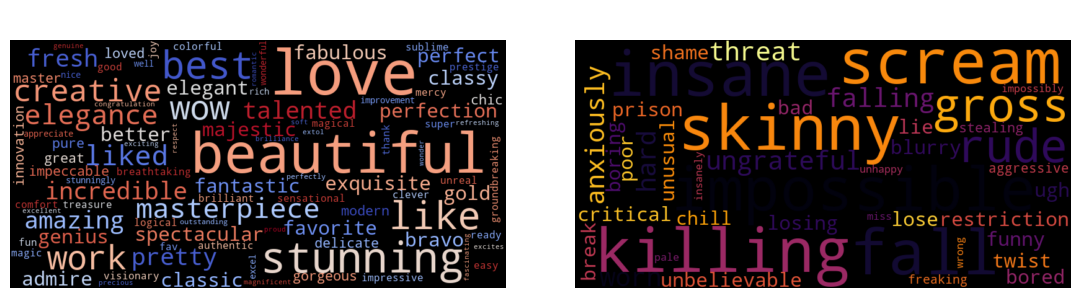

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image

# Optional: You can create a custom shape for the word cloud (e.g., a heart shape)
# heart_mask = np.array(Image.open("path_to_heart_mask.png"))

# Generate Word Cloud for Positive Words with aesthetic customization
positive_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',  # Dark background for better contrast
    colormap='coolwarm',       # Elegant color palette
    max_words=150,             # Limit number of words
    max_font_size=100,         # Set maximum font size
    min_font_size=10,          # Set minimum font size
    font_path=None,            # Specify a custom font path (optional)
    contour_color='white',     # Word cloud contour color
    contour_width=3,           # Contour width for a more defined shape
    random_state=42            # Ensure reproducibility
).generate_from_frequencies(pos_word_counts)

# Generate Word Cloud for Negative Words with aesthetic customization
negative_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',  # Dark background for better contrast
    colormap='inferno',        # Elegant color palette for vibrancy
    max_words=150,             # Limit number of words
    max_font_size=100,         # Set maximum font size
    min_font_size=10,          # Set minimum font size
    font_path=None,            # Specify a custom font path (optional)
    contour_color='white',     # Word cloud contour color
    contour_width=3,           # Contour width for a more defined shape
    random_state=42            # Ensure reproducibility
).generate_from_frequencies(neg_word_counts)

# Plot the positive word cloud
plt.figure(figsize=(12, 6))

# Left plot for positive words
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Positive Words", fontsize=20, color='white')

# Right plot for negative words
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Negative Words", fontsize=20, color='white')

# Adjust layout for better spacing
plt.tight_layout(pad=5)

# Save the word clouds as PNG images
positive_wordcloud.to_file('positive_wordcloud.png')
negative_wordcloud.to_file('negative_wordcloud.png')

# Show the word clouds
plt.show()


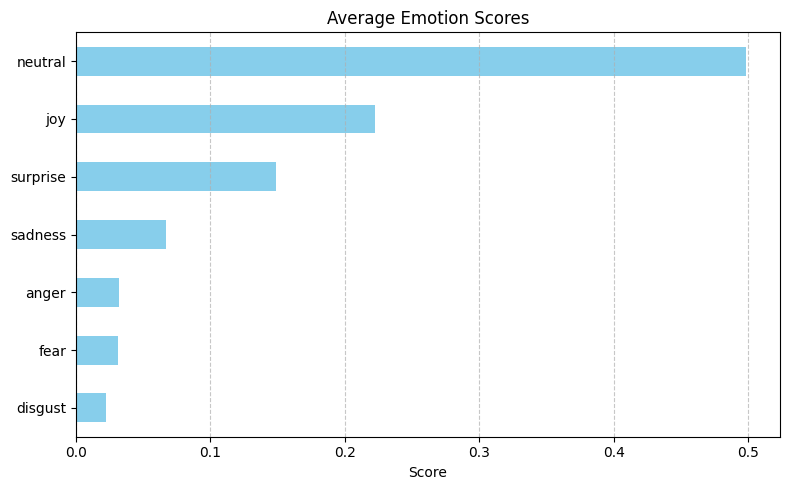

In [15]:
# Expand emotions into separate columns
emotion_df = analysis_df['emotions'].dropna().apply(pd.Series)

# Compute average emotion scores
average_emotions = emotion_df.mean().sort_values(ascending=False)

# Plot Emotion Analysis
plt.figure(figsize=(8, 5))
average_emotions.plot(kind='barh', color='skyblue')
plt.title('Average Emotion Scores')
plt.xlabel('Score')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('average_emotion_scores.png')
plt.show()
